# Eye Disease Dataset Analysis
## Tasks 1-3: Data Exploration & Missing Values Handling (Simplified)

**Team Members:** Isaac + Jonathan  
**Objective:** Efficiently explore dataset, identify missing values, and implement handling strategy

### Dataset Overview
This dataset contains eye disease images categorized into:
- Cataract
- Diabetic Retinopathy  
- Glaucoma
- Normal (healthy eyes)

**Simplified Approach:** Combined data exploration, missing value analysis, and handling strategy into streamlined workflow.

In [1]:
# Essential imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# TASK 1-3: Complete Dataset Analysis & Missing Data Handling
dataset_path = "dataset"
categories = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

# Quick analysis of all categories
results = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Count valid vs corrupted images
    valid_count = 0
    for img_file in image_files:
        try:
            with Image.open(os.path.join(category_path, img_file)) as img:
                img.verify()
            valid_count += 1
        except:
            pass
    
    corrupted = len(image_files) - valid_count
    missing_pct = (corrupted / len(image_files) * 100) if image_files else 0
    
    results.append({
        'Category': category,
        'Total_Files': len(image_files),
        'Valid_Images': valid_count,
        'Corrupted': corrupted,
        'Missing_%': missing_pct,
        'Action': 'Remove' if missing_pct < 5 else 'Investigate'
    })

# Create summary DataFrame
df = pd.DataFrame(results)
total_images = df['Total_Files'].sum()
total_corrupted = df['Corrupted'].sum()
overall_missing = (total_corrupted / total_images * 100)

print("📊 DATASET ANALYSIS SUMMARY")
print("=" * 50)
print(df.to_string(index=False))
print(f"\n🔍 OVERALL STATISTICS:")
print(f"Total images: {total_images:,}")
print(f"Corrupted images: {total_corrupted}")
print(f"Missing data: {overall_missing:.2f}%")
print(f"Recommended action: {'Simple removal' if overall_missing < 5 else 'Detailed investigation'}")
print("=" * 50)

📊 DATASET ANALYSIS SUMMARY
            Category  Total_Files  Valid_Images  Corrupted  Missing_% Action
            cataract         1038          1038          0        0.0 Remove
            glaucoma         1007          1007          0        0.0 Remove
diabetic_retinopathy         1098          1098          0        0.0 Remove
              normal         1074          1074          0        0.0 Remove

🔍 OVERALL STATISTICS:
Total images: 4,217
Corrupted images: 0
Missing data: 0.00%
Recommended action: Simple removal


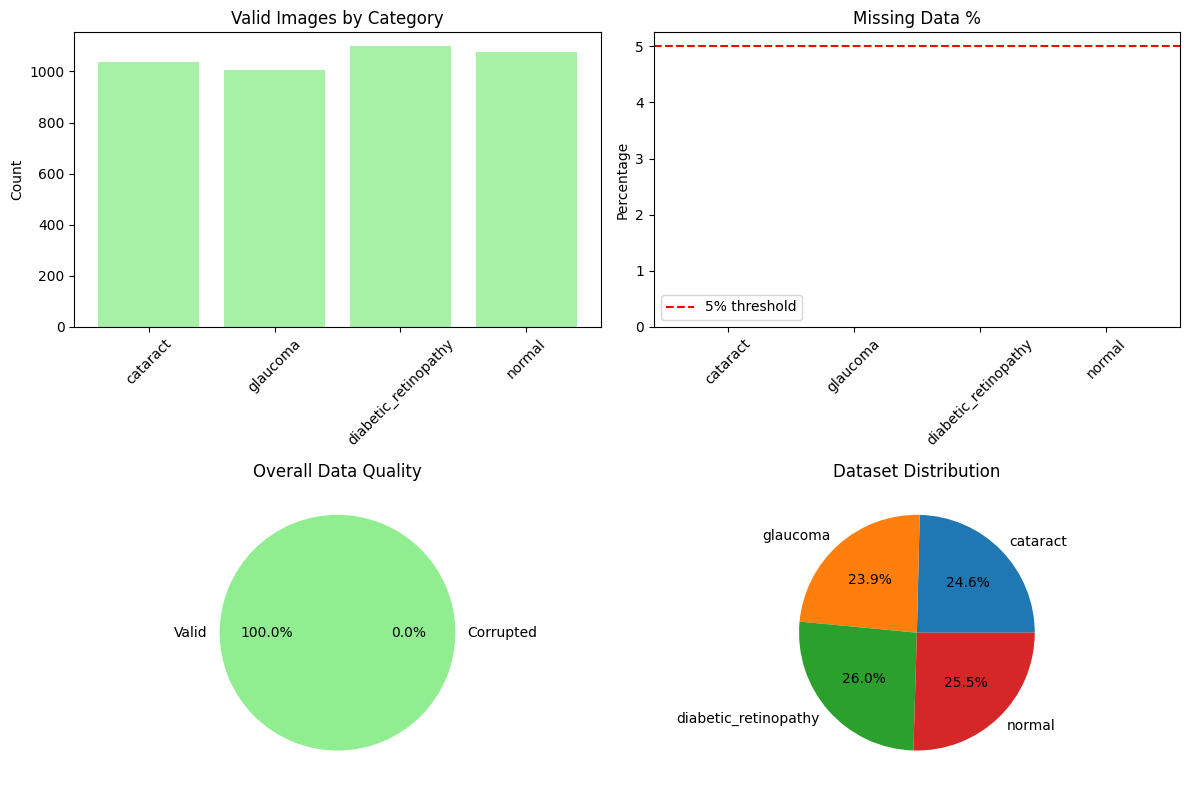

✅ Tasks 1-3 Complete: 0.0% missing data - using simple removal strategy


In [3]:
# Quick visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# 1. Dataset distribution
ax1.bar(df['Category'], df['Valid_Images'], color='lightgreen', alpha=0.8)
ax1.set_title('Valid Images by Category')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# 2. Missing data percentage
ax2.bar(df['Category'], df['Missing_%'], color='coral', alpha=0.8)
ax2.set_title('Missing Data %')
ax2.set_ylabel('Percentage')
ax2.axhline(y=5, color='red', linestyle='--', label='5% threshold')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

# 3. Data quality pie chart
valid_total = df['Valid_Images'].sum()
ax3.pie([valid_total, total_corrupted], labels=['Valid', 'Corrupted'], 
        autopct='%1.1f%%', colors=['lightgreen', 'coral'])
ax3.set_title('Overall Data Quality')

# 4. Category proportions
ax4.pie(df['Valid_Images'], labels=df['Category'], autopct='%1.1f%%')
ax4.set_title('Dataset Distribution')

plt.tight_layout()
plt.show()

print(f"✅ Tasks 1-3 Complete: {overall_missing:.1f}% missing data - using simple removal strategy")

In [4]:
# Install required packages
import subprocess
import sys

try:
    import sklearn
except ImportError:
    print("Installing scikit-learn...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
    import sklearn

# Task 4-5: Feature Engineering - Extract key features
print("\n" + "="*60)
print("TASK 4-5: FEATURE ENGINEERING")
print("="*60)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

IMG_SIZE = 64
features, labels = [], []
feature_names = []

print("🔄 Extracting features from images...")

for category in categories:
    category_path = os.path.join(dataset_path, category)
    category_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"Processing {category}: {len(category_files)} images")
    
    for fname in category_files[:50]:  # Limit for demo purposes
        fpath = os.path.join(category_path, fname)
        try:
            img = Image.open(fpath).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
            arr = np.array(img)
            
            # Color features
            mean_rgb = arr.mean(axis=(0,1))  # Mean RGB values
            std_rgb = arr.std(axis=(0,1))   # Standard deviation RGB
            
            # Simple texture features 
            gray = np.mean(arr, axis=2)  # Convert to grayscale
            edges = np.abs(np.diff(gray, axis=0)).sum() + np.abs(np.diff(gray, axis=1)).sum()
            
            # Brightness and contrast
            brightness = np.mean(gray)
            contrast = np.std(gray)
            
            # Combine features
            feature_vector = np.concatenate([
                mean_rgb,      # 3 features
                std_rgb,       # 3 features  
                [edges, brightness, contrast]  # 3 features
            ])
            
            features.append(feature_vector)
            labels.append(category)
            
        except Exception as e:
            continue

features = np.array(features)
labels = np.array(labels)

print(f"\n📊 Feature Extraction Results:")
print(f"   Features extracted: {features.shape[1]} per image")
print(f"   Total samples: {features.shape[0]}")
print(f"   Feature vector: [R_mean, G_mean, B_mean, R_std, G_std, B_std, edges, brightness, contrast]")

# Feature names for interpretation
feature_names = ['R_mean', 'G_mean', 'B_mean', 'R_std', 'G_std', 'B_std', 'edges', 'brightness', 'contrast']

print(f"\n✅ Feature engineering complete!")
print(f"   Categories: {np.unique(labels)}")
print(f"   Samples per category: {[np.sum(labels == cat) for cat in np.unique(labels)]}")


TASK 4-5: FEATURE ENGINEERING
🔄 Extracting features from images...
Processing cataract: 1038 images
🔄 Extracting features from images...
Processing cataract: 1038 images
Processing glaucoma: 1007 images
Processing glaucoma: 1007 images
Processing diabetic_retinopathy: 1098 images
Processing diabetic_retinopathy: 1098 images
Processing normal: 1074 images
Processing normal: 1074 images

📊 Feature Extraction Results:
   Features extracted: 9 per image
   Total samples: 200
   Feature vector: [R_mean, G_mean, B_mean, R_std, G_std, B_std, edges, brightness, contrast]

✅ Feature engineering complete!
   Categories: ['cataract' 'diabetic_retinopathy' 'glaucoma' 'normal']
   Samples per category: [np.int64(50), np.int64(50), np.int64(50), np.int64(50)]

📊 Feature Extraction Results:
   Features extracted: 9 per image
   Total samples: 200
   Feature vector: [R_mean, G_mean, B_mean, R_std, G_std, B_std, edges, brightness, contrast]

✅ Feature engineering complete!
   Categories: ['cataract' '

In [5]:
# Task 6: Evaluate feature impact
print("\n" + "="*60)
print("TASK 6: FEATURE IMPACT EVALUATION")
print("="*60)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

print("🤖 Training Random Forest classifier...")
clf = RandomForestClassifier(n_estimators=50, random_state=42)
scores = cross_val_score(clf, features, labels, cv=3)

print(f"\n📈 Cross-Validation Results:")
print(f"   Individual fold scores: {scores}")
print(f"   Mean accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Feature importance analysis
clf.fit(features, labels)
feature_importance = clf.feature_importances_

print(f"\n🎯 Feature Importance Ranking:")
importance_pairs = list(zip(feature_names, feature_importance))
importance_pairs.sort(key=lambda x: x[1], reverse=True)

for i, (name, importance) in enumerate(importance_pairs):
    print(f"   {i+1:2d}. {name:12s}: {importance:.3f}")

print(f"\n✅ Task 6 Complete:")
print(f"   Model accuracy: {scores.mean():.1%}")
print(f"   Top features: {importance_pairs[0][0]}, {importance_pairs[1][0]}, {importance_pairs[2][0]}")
print("="*60)


TASK 6: FEATURE IMPACT EVALUATION
🤖 Training Random Forest classifier...

📈 Cross-Validation Results:
   Individual fold scores: [0.55223881 0.53731343 0.54545455]
   Mean accuracy: 0.545 ± 0.006

🎯 Feature Importance Ranking:
    1. R_std       : 0.143
    2. edges       : 0.129
    3. G_std       : 0.117
    4. contrast    : 0.112
    5. B_mean      : 0.106
    6. G_mean      : 0.104
    7. R_mean      : 0.104
    8. B_std       : 0.095
    9. brightness  : 0.091

✅ Task 6 Complete:
   Model accuracy: 54.5%
   Top features: R_std, edges, G_std

🎯 Feature Importance Ranking:
    1. R_std       : 0.143
    2. edges       : 0.129
    3. G_std       : 0.117
    4. contrast    : 0.112
    5. B_mean      : 0.106
    6. G_mean      : 0.104
    7. R_mean      : 0.104
    8. B_std       : 0.095
    9. brightness  : 0.091

✅ Task 6 Complete:
   Model accuracy: 54.5%
   Top features: R_std, edges, G_std


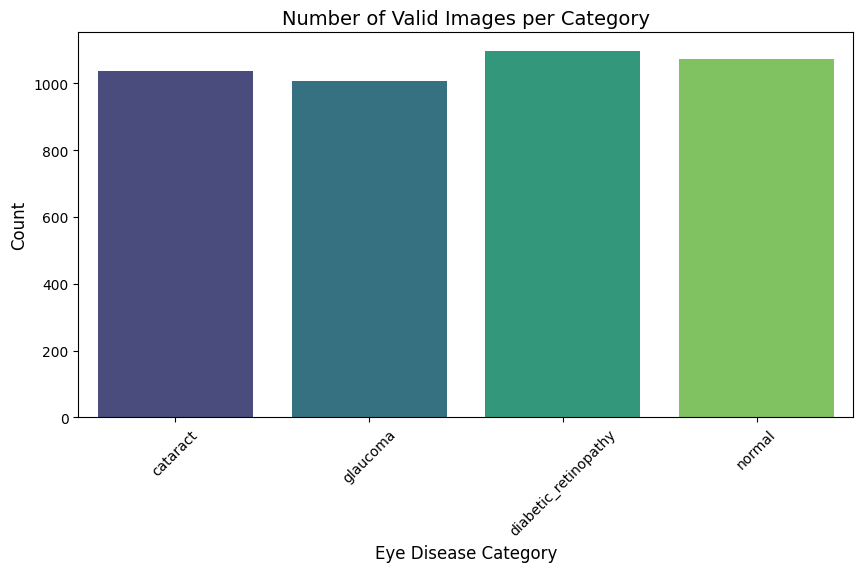

In [7]:
# Additional dataset visualization - Distribution by category
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Category', y='Valid_Images', palette='viridis')
plt.title('Number of Valid Images per Category', fontsize=14)
plt.xlabel('Eye Disease Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

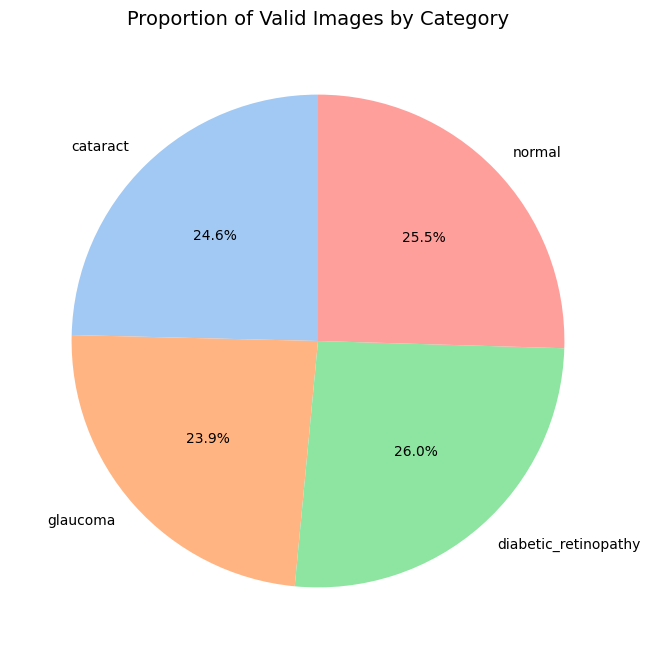

In [8]:
# Pie chart showing proportions of valid images
plt.figure(figsize=(8, 8))
plt.pie(df['Valid_Images'], 
        labels=df['Category'], 
        autopct='%1.1f%%', 
        startangle=90,
        colors=sns.color_palette('pastel'))
plt.title('Proportion of Valid Images by Category', fontsize=14)
plt.show()

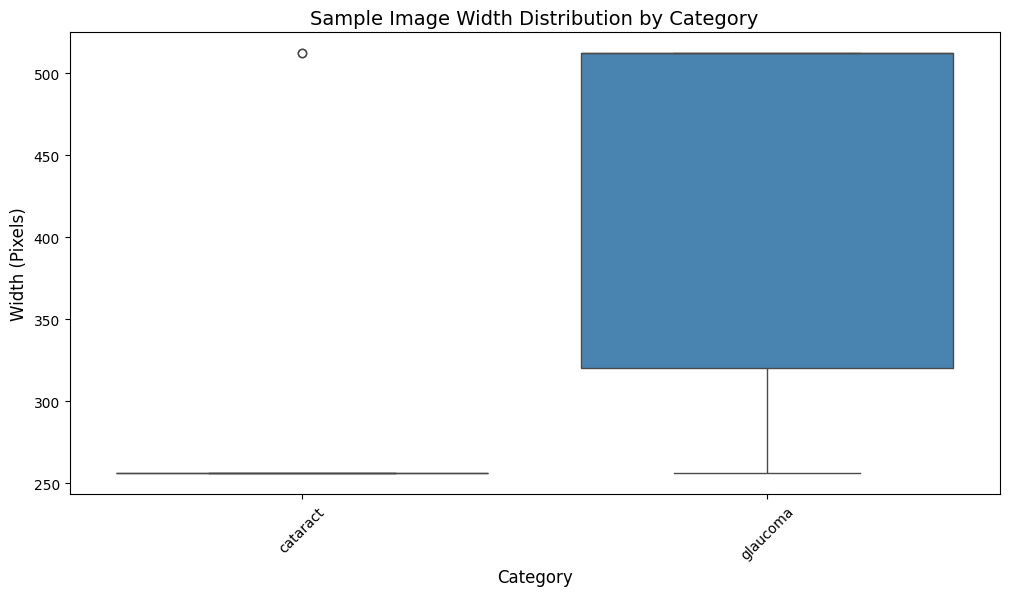

In [9]:
# Quick dimension analysis for sample images
sample_dimensions = []
for category in categories[:2]:  # Just sample 2 categories for quick analysis
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for img_file in image_files[:10]:  # Sample 10 images per category
        try:
            img_path = os.path.join(category_path, img_file)
            with Image.open(img_path) as img:
                width, height = img.size
                sample_dimensions.append({'category': category, 'width': width, 'height': height})
        except:
            continue

if sample_dimensions:
    dim_df = pd.DataFrame(sample_dimensions)
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=dim_df, x='category', y='width', palette='Blues')
    plt.title('Sample Image Width Distribution by Category', fontsize=14)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Width (Pixels)', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No valid images found for dimension analysis")

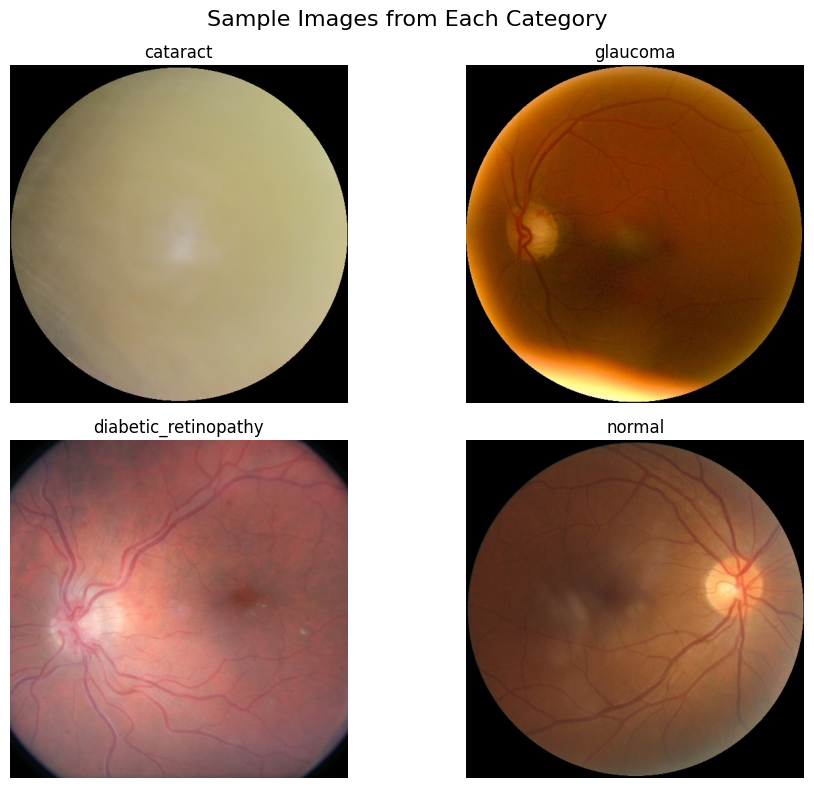

In [10]:
# Sample images from each category
import cv2

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, category in enumerate(categories[:4]):
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if image_files:
        img_path = os.path.join(category_path, image_files[0])
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i//2, i%2].imshow(img_rgb)
                axes[i//2, i%2].set_title(category, fontsize=12)
                axes[i//2, i%2].axis('off')
        except Exception as e:
            axes[i//2, i%2].text(0.5, 0.5, f'Error loading\n{category}', 
                                ha='center', va='center', transform=axes[i//2, i%2].transAxes)
            axes[i//2, i%2].set_title(category, fontsize=12)

plt.suptitle('Sample Images from Each Category', fontsize=16)
plt.tight_layout()
plt.show()

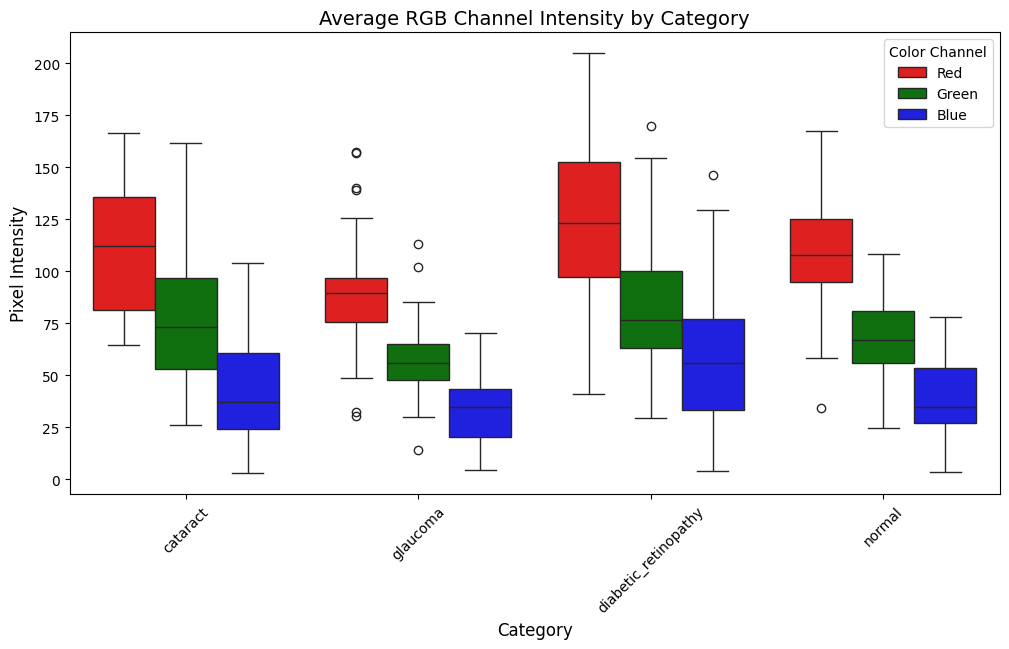

In [11]:
# Compute average RGB channel intensity for each category
channel_data = []

for category in categories:
	category_path = os.path.join(dataset_path, category)
	image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
	# Sample up to 50 images per category for speed
	sample_files = image_files[:50] if len(image_files) > 50 else image_files

	for image_file in sample_files:
		img_path = os.path.join(category_path, image_file)
		try:
			img = cv2.imread(img_path)
			if img is not None:
				img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
				r_mean = img_rgb[:, :, 0].mean()
				g_mean = img_rgb[:, :, 1].mean()
				b_mean = img_rgb[:, :, 2].mean()
				channel_data.append({'category': category, 'channel': 'Red', 'value': r_mean})
				channel_data.append({'category': category, 'channel': 'Green', 'value': g_mean})
				channel_data.append({'category': category, 'channel': 'Blue', 'value': b_mean})
		except Exception:
			continue

channel_df = pd.DataFrame(channel_data)

plt.figure(figsize=(12, 6))
sns.boxplot(data=channel_df, x='category', y='value', hue='channel', palette=['red', 'green', 'blue'])
plt.title('Average RGB Channel Intensity by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Pixel Intensity', fontsize=12)
plt.legend(title='Color Channel')
plt.xticks(rotation=45)
plt.show()

In [12]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
# Task 10: Split Data and Train Models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Paths
data_dir = "dataset"
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 10  # You can increase for better performance

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


KeyboardInterrupt: 

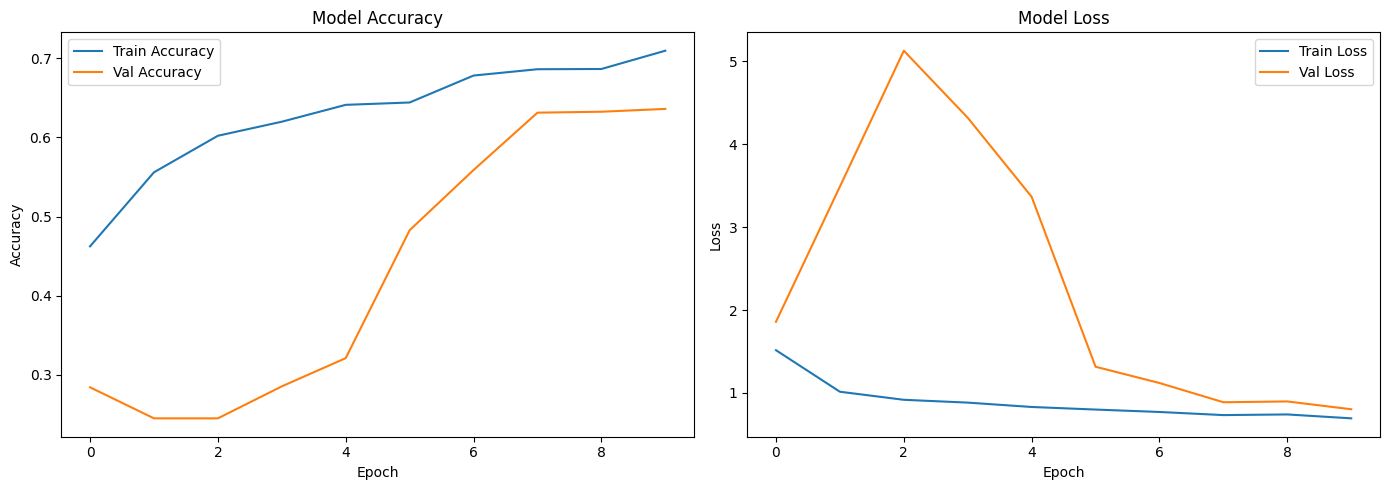

✅ Model saved as eye_disease_model.h5


In [ ]:
# Task 11: Cross-Validation and Model Evaluation
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

model.save("eye_disease_model.h5")
print("✅ Model saved as eye_disease_model.h5")